# Preprocesamiento de la base de datos del clima.

Se mantendrán solo 5 de los 11 climas, el criterio de selección es personal.
La base de datos original se puede acceder desde aqui [Weather image recognition](https://www.kaggle.com/jehanbhathena/weather-dataset?select=dataset).

Los climas utilizados son:
[hail, lighting, rain, sandstorm, snow]

## Librerias

Se importarán las librerias pertinentes para realizar la limpieza y visualización de los datos

- **Numpy**: Librería para manejo de datos y arreglos númericos.
- **Pandas**: Creación de los DataFrame y mejor manejo de los datos.
- **Matplotlib**: Creación de los gráficos y las figuras para visualización de los datos.

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib

In [68]:
# Importamos las librerias principales
import numpy as np
import pandas as pd
import os

# Obtenemos el Sistema operativo y definimos el separador de directorios
OS = os.environ.get('OS')
if OS == 'Windows_NT':
    SEPARATOR = '\\'
else:
    SEPARATOR = '/'

IMG_SIZE = (100, 100, 3)

%matplotlib inline

## Carga del dataset

Al tener imagenes, la base de datos constará únicamente por el nombre del clima, la ubicación y la cantidad de imagenes.

In [3]:
# Función para filtrar los climas de la base de datos
def load_data(path: str, desired_weather:list=None) -> pd.DataFrame:
    """
    Función para cargar los datos de la base de datos.
    param: path: str, ruta de la base de datos.
    param: desired_weather: list, lista de los climas que se quieren cargar.
    return: df: pd.DataFrame, dataframe con los datos de la base de datos.
    """
    # Asignamos en memoria las variables que contendrán las rutas, nombres y cantidad de imagenes por clima.
    paths = []
    weather_name = []
    num_images = []
    # Obtenemos la ruta completa para evitar algún problema.
    full_path = os.path.realpath(path)

    # Recorremos todos los directorios de la base de datos.
    for root, dirs, _ in os.walk(full_path):
        for dir in dirs:
            # Si el clima se encuentra en la lista se almacena.
            if dir in desired_weather:

                paths.append(os.path.join(root, dir))
                weather_name.append(dir)
                num_images.append(len(os.listdir(os.path.join(root, dir))))

            # Si no se da una lista de climas deseados, se cargarán todos.
            elif desired_weather is None:
                paths.append(os.path.join(root, dir))
                weather_name.append(dir)
                num_images.append(len(os.listdir(os.path.join(root, dir))))

    # Se crea un DataFrame que contiene los datos obtenidos.
    df = pd.DataFrame({'weather': weather_name, 'num_images': num_images, 'path': paths})
    return df


# Definimos la ruta de la base de datos y los climas que queremos cargar
db_path = 'dataset/'
desired_weather = ['hail', 'lightning', 'rain', 'sandstorm', 'snow']

# Obtenemos los datos y mostramos una población del Dataframe.
df = load_data(db_path, desired_weather)
df.head(10)

,weather,num_images,path
0,hail,592,D:\Programación\IA center_proyectofinal\weathe...
1,lightning,378,D:\Programación\IA center_proyectofinal\weathe...
2,rain,527,D:\Programación\IA center_proyectofinal\weathe...
3,sandstorm,692,D:\Programación\IA center_proyectofinal\weathe...
4,snow,621,D:\Programación\IA center_proyectofinal\weathe...


Es necesario tener 300 imagenes minimo por clima para entrenar de mejor manera y tener una cantidad decente de muestras para validación y testeo.

Se crea una columna por clima para ver si les hace falta imagenes o no.

In [4]:
# Obtenemos las filas para añadir la cantidad de imagenes restantes.
TOTAL_IMAGES = 300
filas, columnas = df.shape

data_frame_copy = df.copy()

for i in range(filas):
    # Creamos una columna con las imagenes necesarias para tener las 300 imagenes.
    data_frame_copy.loc[i, 'num_images_needed'] = int(TOTAL_IMAGES - data_frame_copy.loc[i, 'num_images'])

data_frame_copy.drop(columns=['path'], inplace=True)
data_frame_copy.head(10)

,weather,num_images,num_images_needed
0,hail,592,-292.0
1,lightning,378,-78.0
2,rain,527,-227.0
3,sandstorm,692,-392.0
4,snow,621,-321.0


Se puede observar que todas las clases cumplen con el minimo de imagenes deseada (300), sin embargo, se puede observar un desbalanceo de clases que pudiera a llevar un peor aprendizaje de los climas con menos muestras. Esto afecta mas fuertemente a **lightning** y en menor medida a **rain**.

-----------------------------------------
-----------------------------------------

## Preprocesamiento de las imagenes

Se llevará a cabo un preprocesamiento de las imagenes para que todas cuenten con las mismas características. 
Las imagenes se normalizarán con las siguientes características: (64,64,3).

Para esta etapa se utilizarán las siguientes librerias:

- **TensorFlow**: Creación del pipeline de entrenamiento y la creación y entrenamiento del modelo.
- **Scikit-Learn**: Dividir la base de datos y aleatorizar los conjuntos de entrenamiento, pruebas y validación. 
- **Skimage**: Cargar las imagenes y normalizar el tamaño.
- **Joblib**: Almacenamiento de la base de datos en memoria.

In [5]:
import tensorflow as tf
# Si entrenas de una gpu propia esta linea puede evitar errores futuros
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
import numpy as np
import joblib

Se obtendrán todas las imagenes de la base de datos y se almacenaran en arreglos.

In [6]:
def load_images(path: str, desired_weather: str, img_size: (int, int, int)) -> np.array:

    """
    Función para cargar las imagenes de un clima.
    """ 
    # Obtenemos la ruta completa para evitar algún problema.
    full_path = os.path.realpath(path)

    # Creamos una lista para almacenar las imagenes.
    X = []
    y = []

    # Recorremos todos los directorios de la base de datos.
    for root, dirs, files in os.walk(full_path):
        weather_name = root.split(SEPARATOR)[-1]
        # Obntenemos el nombre del clima
        print('========================')
        print(weather_name)
        if weather_name in desired_weather:
            for file in files:

                image_path = os.path.join(root, file)
                image = imread(image_path)
                image = resize(image, img_size)

                X.append(image)
                y.append(weather_name)

                '''
                # Recorremos todas las imagenes del clima.
                for image in os.listdir(os.path.join(root, dir)):
                    # Cargamos la imagen.
                    img = load_img(os.path.join(root, dir, image))
                    # Convertimos la imagen a un array.
                    img = np.array(img)
                    # Añadimos la imagen a la lista.
                    images.append(img)
                '''
            
    return np.array(X), y

# Obtenemos la base de datos con las clases deseadas.
X, y = load_images(db_path, desired_weather, img_size=IMG_SIZE)


dataset
dew
fogsmog
frost
glaze
hail
lightning
rain
rainbow
rime
sandstorm
snow


In [7]:
# Observamos que X tenga la dimensión esperada y que y contenga las clases esperadas y la misma cantidad de datos que X
print(X.shape)
print(np.unique(y))
print(len(y))

# Se almacenan los datos en un archivo para no tener que volver a cargarlos.
joblib.dump(X, 'X_1.joblib')
joblib.dump(y, 'y_1.joblib')

(2810, 100, 100, 3)
['hail' 'lightning' 'rain' 'sandstorm' 'snow']
2810


['y_1.joblib']

Obtenemos el conjunto de entrenamiento, pruebas y validación.

Se checa el tamaño del entrenamiento para ver que si sean mas de 200 imagenes.

In [48]:
# Cargamos los datos desde el archivo, en caso de que se haya ejecutado todo desde el principio, esto no será necesario.
X = joblib.load('X_1.joblib')
y = joblib.load('y_1.joblib')

------------------------

# Creación del conjunt ode entrenamiento y de pruebas
Esta seccion consta de la obtención del conjunto de entrenamiento y el de pruebas.
Además, se repliega una muestra de las clases contenidas y se realiza la codifgicación de las clases.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=614)

# Checamos que la clase 'lightning tenga el minimo requerido
lightning_size = len([i for i in y_train if i == 'lightning'])
print('El tamaño de entrenamiento de la clase "lightning es de: ', lightning_size)

El tamaño de entrenamiento de la clase "lightning es de:  269


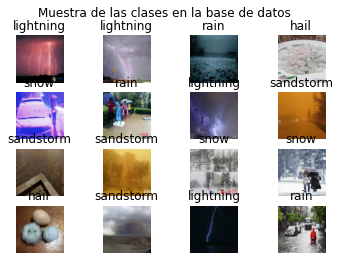

In [69]:
# Obtenemos una muestra visual de las clases en la base de datos.

for i in range(16):
    plt.subplot(4, 4, i+1)
    # Obtenemos una muestra aleatoria
    num = np.random.randint(0, lightning_size)
    # Otenemos la imagen y su etiqueta
    plt.imshow(X_train[num])
    plt.title(y_train[num])
    plt.axis('off')

plt.suptitle('Muestra de las clases en la base de datos')
plt.show()

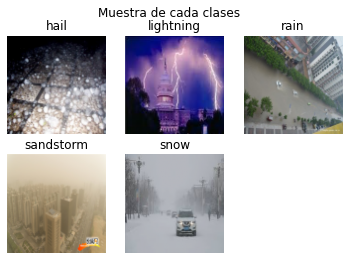

In [70]:
# Grafica que muestre unicamente un ejemplo de cada clase
for i, item in enumerate(np.unique(y_train)):
    plt.subplot(2, 3, i+1)
    # Obtenemos una muestra aleatoria
    for j in range(len(y_train)):
        if y_train[j] == item:
            num = j
            break
    # Otenemos la imagen y su etiqueta
    plt.imshow(X_train[num])
    plt.title(y_train[num])
    plt.axis('off')

plt.suptitle('Muestra de cada clases')
plt.show()    


In [63]:
### Tabla pandas con la cantidad de imagenes por clase en el set de entrenamiento y prueba
def get_shapes(y) -> pd.DataFrame:
    y_shapes = {}
    for i in np.unique(y):
        y_shapes[i] = len([j for j in y if j == i])

    return pd.DataFrame.from_dict(y_shapes, orient='index')

get_shapes(y_train)

,0
hail,408
lightning,269
rain,379
sandstorm,485
snow,426


In [64]:
get_shapes(y_test)

,0
hail,184
lightning,109
rain,148
sandstorm,207
snow,195


### Mapeo de las etiquetas
Se cambiaran las etiquetas a números enteros.

In [11]:
# Creación del diccionario contenedor de clases.
mapping = {}

for i, item in enumerate(np.unique(y_train)):
    mapping[item] = i

# mapeamos
for i in range(len(y_train)): 
    y_train[i] = mapping[y_train[i]]

for i in range(len(y_test)):
    y_test[i] = mapping[y_test[i]]
    

-------------------

# Creación del modelo
Se define el modelo para el entrenamiento.

El modelo a utilizar esta basado en la red AlexNet

In [41]:
class AlexNetModified:
    """
    Clase para crear un modelo tipo AlexNet.
    params: input_shape: Tamaño de la imagen de entrada.
    params: num_classes: Número de clases.
    """
    def __init__(self, input_shape=(64, 64, 3), num_classes=5):
        # Constructor de la clase.
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.history = None


    def BuildFullModel(self) -> tf.keras.Model:
        """
        Construcción del modelo de red.
        Se basa en el modelo de AlexNet obtenido del libro d2l.ai
        La liga completa es la siguiente: http://d2l.ai/chapter_convolutional-modern/alexnet.html
        """
        
        # Se crea un modelo tipo secuencial.
        model = tf.keras.Sequential()
        # Se comienzan a añadir las capas.
        # Primer bloque convolucional
        model.add(layers.Conv2D(filters=96, kernel_size=11, strides=4, padding='valid', activation='relu', input_shape=self.input_shape))
        model.add(layers.MaxPool2D(pool_size=3, strides=2))
        # Segundo bloque convolucional
        model.add(layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'))
        model.add(layers.MaxPool2D(pool_size=3, strides=2))
        # Tercer bloque convolucional
        model.add(layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))
        model.add(layers.MaxPool2D(pool_size=3, strides=2))
        # Bloques Fully Connected
        model.add(layers.Flatten())
        model.add(layers.Dense(units=4096, activation='relu'))
        model.add(layers.Dropout(rate=0.5))
        model.add(layers.Dense(units=4096, activation='relu'))
        model.add(layers.Dropout(rate=0.5))
        model.add(layers.Dense(units=self.num_classes, activation='softmax'))

        # Muestra el resumen del modelo
        model.summary()
        return model

    def BuildSmallModel(self) -> tf.keras.Model:
        """
        Construcción del modelo de red.
        Se basa en el modelo de AlexNet reducido basado del libro d2l.ai
        La liga completa es la siguiente: http://d2l.ai/chapter_convolutional-modern/alexnet.html
        """
        model = tf.keras.Sequential()
        # Primer bloque convolucional
        model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape))
        model.add(layers.MaxPool2D((2, 2)))
        # Segundo bloque convolucional
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPool2D((2, 2)))
        # Tercer bloque convolucional
        model.add(layers.Conv2D(128, (3, 3), activation='relu'))
        model.add(layers.MaxPool2D((2, 2)))
        # Cuarto bloque convolucional
        model.add(layers.Conv2D(256, (3, 3), activation='relu'))
        model.add(layers.MaxPool2D((2, 2)))
        # Bloques Fully Connected
        model.add(layers.Flatten())
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(4096, activation='relu'))
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(self.num_classes, activation='softmax'))

        # Muestra el resumen del modelo
        model.summary()
        return model

    def vggModel(self) -> tf.keras.Model:
        """
        Mo delo tipo VGG con 5 bloques convolucionales.
        El modelo se obtuvo de: http://d2l.ai/chapter_convolutional-modern/vgg.html
        """
        # Definimos la función de construcción de los bloques VGG
        def vgg_block(num_convs, num_channels):
            blk = tf.keras.Sequential()
            for _ in range(num_convs):
                blk.add(layers.Conv2D(num_channels, kernel_size=3, activation='relu', padding='same'))
            blk.add(layers.MaxPool2D(pool_size=2, strides=2))
            return blk


        # Se define las capas convolucionales y el número de filtros
        conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

        model = tf.keras.Sequential()
        # Se añaden los bloques convolucionales
        for (num_layers, num_filters) in conv_arch:
            model.add(vgg_block(num_convs=num_layers, num_channels=num_filters))

        # Se añade la capa fully connected
        model.add(
            tf.keras.models.Sequential([
                layers.Flatten(),
                layers.Dense(4096, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(4096, activation='relu'),
                layers.Dropout(0.5),
                layers.Dense(self.num_classes, activation='softmax')
            ])
        )
        return model

    def CompileModel(self, model=None) -> tf.keras.Model:
        """
        Compilación del modelo.
        Se utiliza el optimizador Adam con una función de pérdida categórica.
        """

        if model is None:
            model = self.model

        model.compile(
            optimizer='adam', 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
            metrics=['accuracy', 'mse']
        )

        return model
        
    def TrainModel(self, X_train, y_train, X_test, y_test, epochs=50, batch_size=30, model=None):
        """
        Entrenamiento del modelo.
        params: model: Modelo a entrenar.
        params: X_train: Datos de entrenamiento.
        params: y_train: Etiquetas de entrenamiento.
        params: X_test: Datos de prueba.
        params: y_test: Etiquetas de prueba.
        params: epochs: Número de iteraciones.
        params: batch_size: Tamaño del lote.
        """

        if model is None:
            model = self.model

        history = model.fit(
            X_train, 
            y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=(X_test, y_test)
        )
        self.history = history
        return history, model

    def ShowPlots(self, history=None):
        """
        Visualización del entrenamiento del modelo.
        """
        if history is None:
            history = self.history	 

        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')

In [42]:
# Instanciamos el modelo
model_constructor = AlexNetModified(input_shape=IMG_SIZE, num_classes=5)

# Construimos el modelo y lo compilamos
model = model_constructor.BuildFullModel()
model = model_constructor.CompileModel(model)

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 23, 23, 96)        34944     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 11, 11, 256)       614656    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 5, 5, 384)         885120    
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 5, 5, 384)         1327488   
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 5, 5, 256)       

In [43]:
# Exploramos la salida de cada capa
sx, sy, sz = IMG_SIZE
prueba = tf.random.uniform((1, sx, sy, sz))
for layer in model.layers:
    prueba = layer(prueba)
    print(layer.__class__.__name__, 'tamaño de salida:\t', prueba.shape)

Conv2D tamaño de salida:	 (1, 23, 23, 96)
MaxPooling2D tamaño de salida:	 (1, 11, 11, 96)
Conv2D tamaño de salida:	 (1, 11, 11, 256)
MaxPooling2D tamaño de salida:	 (1, 5, 5, 256)
Conv2D tamaño de salida:	 (1, 5, 5, 384)
Conv2D tamaño de salida:	 (1, 5, 5, 384)
Conv2D tamaño de salida:	 (1, 5, 5, 256)
MaxPooling2D tamaño de salida:	 (1, 2, 2, 256)
Flatten tamaño de salida:	 (1, 1024)
Dense tamaño de salida:	 (1, 4096)
Dropout tamaño de salida:	 (1, 4096)
Dense tamaño de salida:	 (1, 4096)
Dropout tamaño de salida:	 (1, 4096)
Dense tamaño de salida:	 (1, 5)


In [44]:
# Entrenamiento del modelo
#  X_train, y_train, X_test, y_test, epochs=50, batch_size=30, model=None
'''
history, model = model_constructor.TrainModel(X_train=X_train, 
                                              y_train=np.array(y_train), 
                                              X_test=X_test, 
                                              y_test=np.array(y_test), 
                                              epochs=50, 
                                              batch_size=30, model=model
                                              )
'''

history = model.fit(
    np.asarray(X_train), 
    np.asarray(y_train), 
    epochs=45, 
    batch_size=60, 
    validation_data=(np.asarray(X_test), np.asarray(y_test))
)

Epoch 1/45
33/33 [==============================] - 1s 26ms/step - loss: 1.6427 - accuracy: 0.2255 - mse: 5.7649 - val_loss: 1.4167 - val_accuracy: 0.3357 - val_mse: 5.9434
Epoch 2/45
33/33 [==============================] - 1s 18ms/step - loss: 1.4444 - accuracy: 0.3285 - mse: 5.8416 - val_loss: 1.2546 - val_accuracy: 0.4935 - val_mse: 5.9561
Epoch 3/45
33/33 [==============================] - 1s 19ms/step - loss: 1.3891 - accuracy: 0.3771 - mse: 5.7493 - val_loss: 1.2829 - val_accuracy: 0.4152 - val_mse: 5.9524
Epoch 4/45
33/33 [==============================] - 1s 19ms/step - loss: 1.2710 - accuracy: 0.4194 - mse: 6.0035 - val_loss: 1.2861 - val_accuracy: 0.4543 - val_mse: 5.9649
Epoch 5/45
33/33 [==============================] - 1s 19ms/step - loss: 1.1675 - accuracy: 0.4981 - mse: 5.6932 - val_loss: 0.9645 - val_accuracy: 0.6275 - val_mse: 5.9882
Epoch 6/45
33/33 [==============================] - 1s 19ms/step - loss: 0.9467 - accuracy: 0.6207 - mse: 5.9769 - val_loss: 0.8522 - v

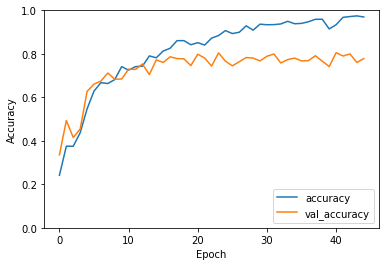

In [45]:
# Observamos las gráficas del entrenamiento
model_constructor.ShowPlots(history=history)

In [33]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 8, 8, 256)       